#### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import argparse
import os
import random
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as utils
import torchvision.models as models

from PIL import Image

import requests, sys, pathlib

Check to see if GPU is availble

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cpu')

print('Device:', device)

Device: cuda:0


Download the dataset from miniImageNet

In [3]:
import gdown, tarfile

url = 'https://drive.google.com/uc?id=107FTosYIeBn5QbynR46YG91nHcJ70whs'
path = './Data/miniImageNet/'
output = './Data/miniImageNet/train.tar'

if not os.path.exists(path):
  os.mkdir('Data')
  os.mkdir(path)

if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

    with tarfile.open(output, 'r') as tar:
        tar.extractall(path)

Downloading...
From: https://drive.google.com/uc?id=107FTosYIeBn5QbynR46YG91nHcJ70whs
To: /content/Data/miniImageNet/train.tar
100%|██████████| 126M/126M [00:01<00:00, 94.0MB/s]


#### 2. Create Datasets

In this section I will create a dataset class.
As instructed I will only consider the train images from the images.

I used 60% of each class images for training and 20% for validation and 20% for testing the model.

In [4]:
import math

train_data_dir_path = './Data/miniImageNet/train/'
miniImageNet_data_dir = pathlib.Path(train_data_dir_path)

# Dataset uses the folder name as its labels
subfolder_names = [subfolder.name for subfolder in miniImageNet_data_dir.glob('*') if subfolder.is_dir()]

miniImageNet_label_dict_idx_key = {idx: label for idx, label in enumerate(subfolder_names)}
miniImageNet_label_dict_label_key = {label: idx for idx, label in enumerate(subfolder_names)}

train_indices = []
valid_indices = []
test_indices = []

# all_data = []
all_img_paths = []
all_data_labels = []

for subfolder in miniImageNet_data_dir.iterdir():
  label_name = subfolder.name
  count = 0 #This count keeps track of the images count for a particular class

  for item in subfolder.iterdir():
    all_img_paths.append(str(item))
    all_data_labels.append(miniImageNet_label_dict_label_key[label_name])
    count +=1
  all_data_size = len(all_img_paths)

  # get train indices
  start_index = all_data_size - count
  end_index = start_index + math.ceil(count * 0.6)
  train_indices.extend(range(start_index, end_index, 1))

  # get validation indices
  start_index = end_index
  end_index = start_index + math.ceil(count * 0.2)
  valid_indices.extend(range(start_index, end_index, 1))

  # get test indices
  start_index = end_index
  end_index = start_index + math.ceil(count * 0.2)
  test_indices.extend(range(start_index, end_index, 1))

class MiniImageNet(Dataset):

  def __init__(self, phase="train", transform=None):

    all_data_paths_np = np.array(all_img_paths)
    all_data_labels_np = np.array(all_data_labels)

    if 'train' == phase:
        self.data = [np.array(cv2.imread(str(item))) for item in all_data_paths_np[train_indices]]
        self.labels = all_data_labels_np[train_indices]

    elif 'valid' == phase:
        self.data = [np.array(cv2.imread(str(item))) for item in all_data_paths_np[valid_indices]]
        self.labels = all_data_labels_np[valid_indices]

    elif 'test' == phase:
        self.data = [np.array(cv2.imread(str(item))) for item in all_data_paths_np[test_indices]]
        self.labels = all_data_labels_np[test_indices]

    else:
        assert True, 'wrong phase'

    self.transform = transform

    self.label_names = np.array(list(miniImageNet_label_dict_idx_key.keys()))

  def __len__(self):
      return len(self.data)

  def __getitem__(self, index):

      img, label = self.data[index], self.labels[index]

      img = Image.fromarray(img, mode='RGB')

      if self.transform is not None:
          img = self.transform(img)

      return img, label

print("Total Number of images in miniImageNet dataset {}".format(len(all_img_paths)))

Total Number of images in miniImageNet dataset 38400


DataLoader for miniImageNet

In [5]:
# Initialize the Weight Transforms
weights = models.ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

# Set batch_size to 8, shuffling the training set. Number of workers here is set to 2
data_transform = transforms.Compose([
    transforms.Lambda(lambda x: preprocess(x)),
    # transforms.RandomResizedCrop(84),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomRotation(degrees=15),
    # transforms.ToTensor()
    ])

train_set = MiniImageNet(phase='train', transform=data_transform)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

valid_set = MiniImageNet(phase='valid', transform=data_transform)
valid_loader = DataLoader(valid_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

test_set = MiniImageNet(phase='test', transform=data_transform)
test_loader = DataLoader(test_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

In the next step I check the dataset and its validity

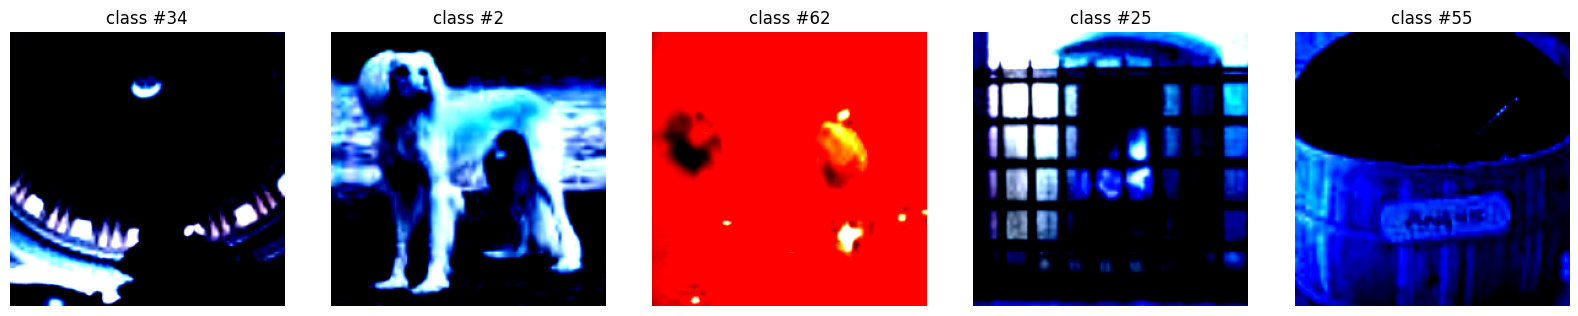

In [6]:
num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False) # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))


for i in range(len(idx)):
    image, label = train_set[idx[i]]
    label_name = train_set.label_names[label]
    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image.permute(1, 2, 0)))


plt.show()

# print number of images for each class
print('total number of training set: {}'.format(len(train_set)))
for i in range(5):
    print('numer of images for class {}: {}'.format(train_set.label_names[i], np.sum(train_set.labels==i)))

#### 3. Methods to save the model

In [7]:
def save_model_dict(model, save_path):

  if not os.path.exists(save_path):
    os.mkdir('Model')

  # Save the model
  torch.save(model.state_dict(), save_path)

In [8]:
# Save full model with architecture
def save_model(model, save_path):
  torch.save(model, save_path)

#### 4. Pretrain the model

Now that the datasets are created I will pretrain a model.

1. get the model architecture using pytorch (Resnet-18 is selected as the model)
2. train each layer and find weights
3. miniImageNet dataset is used to train the model

In [ ]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


def train_model(epochs, dropout, optimizer_params=(0.001, 0.9, 0), optimizer="SGD"):

  resnet_18_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

  num_of_features = resnet_18_model.fc.in_features

  learn_rate, momentum, weight_decay = optimizer_params

  resnet_18_model.fc = nn.Sequential(
      nn.Linear(num_of_features, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),
      nn.Dropout(dropout),
      nn.Linear(512, len(train_set.label_names))
  ).to(device)

  # Define a loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  if(optimizer == "SGD"):
    optimizer = optim.SGD(resnet_18_model.parameters(), lr=learn_rate, momentum=momentum, weight_decay=weight_decay)
  else:
    optimizer = optim.Adam(resnet_18_model.parameters(), lr=learn_rate)
  scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

  # Training loop
  num_epochs = epochs

  for epoch in range(num_epochs):
      resnet_18_model.train()

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          # Forward pass
          outputs = resnet_18_model(inputs)

          loss = criterion(outputs, labels)

          # Backward pass
          loss.backward()
          optimizer.step()

      scheduler.step()
      # Validation
      resnet_18_model.eval()
      total_val_accuracy = 0.0
      with torch.no_grad():
          for inputs, labels in valid_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = resnet_18_model(inputs)
              accuracy = calculate_accuracy(outputs, labels)
              total_val_accuracy += accuracy

          average_val_accuracy = total_val_accuracy / len(valid_loader)
          print(f'Epoch : {epoch}, Validation Accuracy: {average_val_accuracy * 100:.2f}%, loss: {loss}')


  # Test the model on the test set
  resnet_18_model.eval()
  total_test_accuracy = 0.0
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = resnet_18_model(inputs)
          accuracy = calculate_accuracy(outputs, labels)
          total_test_accuracy += accuracy

      average_test_accuracy = total_test_accuracy / len(test_loader)
      print(f'Test Accuracy: {average_test_accuracy * 100:.2f}%')

  print(f"saving the model to {save_path}")
  save_model(resnet_18_model, save_path)

Finetune with dropout

In [ ]:
save_path = './drive/MyDrive/Colab Notebooks/resnet18-dropoout-point1.pth'
train_model(epochs=10, dropout=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.2MB/s]


Epoch : 0, Validation Accuracy: 73.06%, loss: 1.8841830492019653
Epoch : 1, Validation Accuracy: 74.27%, loss: 0.9765411019325256
Epoch : 2, Validation Accuracy: 75.38%, loss: 1.4774761199951172
Epoch : 3, Validation Accuracy: 75.83%, loss: 0.11181557178497314
Epoch : 4, Validation Accuracy: 75.95%, loss: 0.9176192283630371
Epoch : 5, Validation Accuracy: 79.54%, loss: 0.11091449856758118
Epoch : 6, Validation Accuracy: 80.14%, loss: 0.09477966278791428
Epoch : 7, Validation Accuracy: 80.56%, loss: 0.010710521601140499
Epoch : 8, Validation Accuracy: 80.96%, loss: 0.3095644414424896
Epoch : 9, Validation Accuracy: 80.66%, loss: 0.2209964096546173
Test Accuracy: 80.23%
saving the model to ./drive/MyDrive/Colab Notebooks/resnet18-dropoout-point1.pth


In [ ]:
save_path = './drive/MyDrive/Colab Notebooks/resnet18-dropoout-point5.pth'
train_model(epochs=8, dropout=0.5)

Epoch : 0, Validation Accuracy: 70.72%, loss: 0.8229479193687439
Epoch : 1, Validation Accuracy: 71.91%, loss: 1.2804077863693237
Epoch : 2, Validation Accuracy: 73.39%, loss: 1.6440455913543701
Epoch : 3, Validation Accuracy: 72.71%, loss: 1.6465338468551636
Epoch : 4, Validation Accuracy: 73.79%, loss: 0.6361895203590393
Epoch : 5, Validation Accuracy: 78.78%, loss: 0.09182646125555038
Epoch : 6, Validation Accuracy: 79.69%, loss: 0.10213283449411392
Epoch : 7, Validation Accuracy: 79.87%, loss: 0.22595591843128204
Test Accuracy: 79.21%
saving the model to ./drive/MyDrive/Colab Notebooks/resnet18-dropoout-point5.pth


In [ ]:
save_path = './drive/MyDrive/Colab Notebooks/resnet18-dropoout-point9.pth'
train_model(epochs=8, dropout=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 92.1MB/s]


Epoch : 0, Validation Accuracy: 38.32%, loss: 4.018749713897705
Epoch : 1, Validation Accuracy: 53.18%, loss: 2.657827615737915
Epoch : 2, Validation Accuracy: 58.70%, loss: 2.967287063598633
Epoch : 3, Validation Accuracy: 65.20%, loss: 1.1284998655319214
Epoch : 4, Validation Accuracy: 65.74%, loss: 1.2595254182815552
Epoch : 5, Validation Accuracy: 71.85%, loss: 1.1607728004455566
Epoch : 6, Validation Accuracy: 72.58%, loss: 2.598607063293457
Epoch : 7, Validation Accuracy: 73.10%, loss: 0.43194669485092163
Test Accuracy: 72.73%
saving the model to ./drive/MyDrive/Colab Notebooks/resnet18-dropoout-point9.pth


In [ ]:
save_path = './drive/MyDrive/Colab Notebooks/resnet18-dropoout-epoch10-point8.pth'
train_model(epochs=10, dropout=0.8)

Epoch : 0, Validation Accuracy: 63.68%, loss: 1.7407245635986328
Epoch : 1, Validation Accuracy: 68.80%, loss: 1.607771396636963
Epoch : 2, Validation Accuracy: 68.76%, loss: 2.370144844055176
Epoch : 3, Validation Accuracy: 70.98%, loss: 1.2943466901779175
Epoch : 4, Validation Accuracy: 72.28%, loss: 0.7818253040313721
Epoch : 5, Validation Accuracy: 77.58%, loss: 0.8160392642021179
Epoch : 6, Validation Accuracy: 77.98%, loss: 0.27782389521598816
Epoch : 7, Validation Accuracy: 78.36%, loss: 1.284985065460205
Epoch : 8, Validation Accuracy: 78.19%, loss: 0.8655375838279724
Epoch : 9, Validation Accuracy: 78.50%, loss: 0.5450767874717712
Test Accuracy: 78.09%
saving the model to ./drive/MyDrive/Colab Notebooks/resnet18-dropoout-epoch10-point8.pth


Change starting learning rate. I have added a learning rate scheduler so it changes every 5 steps anyway

In [ ]:
save_path = './drive/MyDrive/Colab Notebooks/resnet18-lr-point0001.pth'
train_model(epochs=8, dropout=0.5, optimizer_params=(0.0001, 0.9, 0))

Epoch : 0, Validation Accuracy: 58.59%, loss: 2.7582645416259766
Epoch : 1, Validation Accuracy: 70.20%, loss: 2.101732015609741
Epoch : 2, Validation Accuracy: 74.82%, loss: 1.0974560976028442
Epoch : 3, Validation Accuracy: 77.94%, loss: 1.387121319770813
Epoch : 4, Validation Accuracy: 79.32%, loss: 1.5978238582611084
Epoch : 5, Validation Accuracy: 79.74%, loss: 0.5224457383155823
Epoch : 6, Validation Accuracy: 79.91%, loss: 1.8054331541061401
Epoch : 7, Validation Accuracy: 80.05%, loss: 0.5747546553611755
Test Accuracy: 79.52%
saving the model to ./drive/MyDrive/Colab Notebooks/resnet18-lr-point0001.pth


Weight decay optimization

In [ ]:
save_path = './drive/MyDrive/Colab Notebooks/resnet18-weightdecay-1e-5.pth'
train_model(epochs=8, dropout=0.5, optimizer_params=(0.0001, 0.9, 1e-5))

Epoch : 0, Validation Accuracy: 57.66%, loss: 3.0705888271331787
Epoch : 1, Validation Accuracy: 70.81%, loss: 1.3106683492660522
Epoch : 2, Validation Accuracy: 75.07%, loss: 2.3485958576202393
Epoch : 3, Validation Accuracy: 77.73%, loss: 1.8682610988616943
Epoch : 4, Validation Accuracy: 79.04%, loss: 1.3817187547683716
Epoch : 5, Validation Accuracy: 79.73%, loss: 0.8152512907981873
Epoch : 6, Validation Accuracy: 80.46%, loss: 0.7711805701255798
Epoch : 7, Validation Accuracy: 80.36%, loss: 1.1886353492736816
Test Accuracy: 79.69%
saving the model to ./drive/MyDrive/Colab Notebooks/resnet18-weightdecay-1e-5.pth


In [ ]:
save_path = './drive/MyDrive/Colab Notebooks/resnet18-weightdecay-1e-2.pth'
train_model(epochs=8, dropout=0.5, optimizer_params=(0.001, 0.9, 1e-2))

Epoch : 0, Validation Accuracy: 68.20%, loss: 2.270996570587158
Epoch : 1, Validation Accuracy: 67.64%, loss: 1.921919584274292
Epoch : 2, Validation Accuracy: 63.68%, loss: 1.7959333658218384
Epoch : 3, Validation Accuracy: 58.11%, loss: 2.500847816467285
Epoch : 4, Validation Accuracy: 57.07%, loss: 1.8181793689727783
Epoch : 5, Validation Accuracy: 73.01%, loss: 0.739447832107544
Epoch : 6, Validation Accuracy: 74.64%, loss: 1.159764051437378
Epoch : 7, Validation Accuracy: 74.41%, loss: 0.3839816153049469
Test Accuracy: 74.84%
saving the model to ./drive/MyDrive/Colab Notebooks/resnet18-weightdecay-1e-2.pth


Optimze momentum

In [ ]:
save_path = './drive/MyDrive/Colab Notebooks/resnet18-weightdecay-1e-2.pth'
train_model(epochs=8, dropout=0.5, optimizer_params=(0.001, 0.5, 1e-2))

Epoch : 0, Validation Accuracy: 67.86%, loss: 1.5153100490570068
Epoch : 1, Validation Accuracy: 76.02%, loss: 0.7134472131729126
Epoch : 2, Validation Accuracy: 79.27%, loss: 1.3273515701293945
Epoch : 3, Validation Accuracy: 80.12%, loss: 0.7523764967918396
Epoch : 4, Validation Accuracy: 81.09%, loss: 0.7313383221626282
Epoch : 5, Validation Accuracy: 82.04%, loss: 0.36733686923980713
Epoch : 6, Validation Accuracy: 82.41%, loss: 0.2986122965812683
Epoch : 7, Validation Accuracy: 82.47%, loss: 0.29959750175476074
Test Accuracy: 81.61%
saving the model to ./drive/MyDrive/Colab Notebooks/resnet18-weightdecay-1e-2.pth


Adam optimizer

In [ ]:
save_path = './drive/MyDrive/Colab Notebooks/resnet18-adam-optim.pth'
train_model(epochs=8, dropout=0.5, optimizer_params=(0.001, 0.5, 1e-2), optimizer="Adam")

Epoch : 0, Validation Accuracy: 10.82%, loss: 3.421387195587158
Epoch : 1, Validation Accuracy: 16.47%, loss: 3.366546392440796
Epoch : 2, Validation Accuracy: 20.53%, loss: 3.4478676319122314
Epoch : 3, Validation Accuracy: 26.50%, loss: 2.6840076446533203
Epoch : 4, Validation Accuracy: 27.54%, loss: 2.7177488803863525
Epoch : 5, Validation Accuracy: 35.12%, loss: 3.920048713684082
Epoch : 6, Validation Accuracy: 35.43%, loss: 3.825352430343628
Epoch : 7, Validation Accuracy: 35.74%, loss: 1.8826899528503418
Test Accuracy: 36.07%
saving the model to ./drive/MyDrive/Colab Notebooks/resnet18-adam-optim.pth


Data Augmentation

In [ ]:
# Set batch_size to 8, shuffling the training set. Number of workers here is set to 2
data_transform = transforms.Compose([
    # transforms.Lambda(lambda x: preprocess(x)),
    # transforms.RandomResizedCrop(84),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor()
    ])

train_set = MiniImageNet(phase='train', transform=data_transform)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

valid_set = MiniImageNet(phase='valid', transform=data_transform)
valid_loader = DataLoader(valid_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

test_set = MiniImageNet(phase='test', transform=data_transform)
test_loader = DataLoader(test_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

save_path = './drive/MyDrive/Colab Notebooks/resnet18-augmentation-1.pth'
train_model(epochs=8, dropout=0.5, optimizer_params=(0.001, 0.5, 1e-2))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


Epoch : 0, Validation Accuracy: 41.48%, loss: 2.9822607040405273
Epoch : 1, Validation Accuracy: 52.24%, loss: 1.7637970447540283
Epoch : 2, Validation Accuracy: 57.04%, loss: 1.2320191860198975
Epoch : 3, Validation Accuracy: 59.88%, loss: 1.4724407196044922
Epoch : 4, Validation Accuracy: 60.64%, loss: 1.8565208911895752
Epoch : 5, Validation Accuracy: 62.41%, loss: 1.7797303199768066
Epoch : 6, Validation Accuracy: 63.53%, loss: 2.203784704208374
Epoch : 7, Validation Accuracy: 64.35%, loss: 2.035015344619751
Test Accuracy: 63.16%
saving the model to ./drive/MyDrive/Colab Notebooks/resnet18-augmentation-1.pth


In [ ]:
# Initialize the Weight Transforms
weights = models.ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

# Set batch_size to 8, shuffling the training set. Number of workers here is set to 2
data_transform = transforms.Compose([
    transforms.Lambda(lambda x: preprocess(x)),
    # transforms.RandomResizedCrop(84),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomRotation(degrees=15),
    # transforms.ToTensor()
    ])

train_set = MiniImageNet(phase='train', transform=data_transform)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

valid_set = MiniImageNet(phase='valid', transform=data_transform)
valid_loader = DataLoader(valid_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

test_set = MiniImageNet(phase='test', transform=data_transform)
test_loader = DataLoader(test_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

save_path = './drive/MyDrive/Colab Notebooks/resnet18-augmentation-2.pth'
train_model(epochs=8, dropout=0.5, optimizer_params=(0.001, 0.5, 1e-2))

Epoch : 0, Validation Accuracy: 68.82%, loss: 2.4531826972961426
Epoch : 1, Validation Accuracy: 75.94%, loss: 1.6523276567459106
Epoch : 2, Validation Accuracy: 78.28%, loss: 1.2820582389831543
Epoch : 3, Validation Accuracy: 79.51%, loss: 0.6266549825668335
Epoch : 4, Validation Accuracy: 80.26%, loss: 0.8369947075843811
Epoch : 5, Validation Accuracy: 81.51%, loss: 0.41317713260650635
Epoch : 6, Validation Accuracy: 81.81%, loss: 0.5712858438491821
Epoch : 7, Validation Accuracy: 81.50%, loss: 0.32599326968193054
Test Accuracy: 81.45%
saving the model to ./drive/MyDrive/Colab Notebooks/resnet18-augmentation-2.pth


#### 5. Fine tune the pretrained model with EuroSAT_RGB images.

Download the dataset from EuroSAT(RGB)

In [9]:
import zipfile

link = 'https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1'
destination = './Data/EuroSAT_RGB.zip'

if not os.path.exists(destination):
  # If the Data folder already exists please comment this line
  # os.mkdir('Data')
  # Send a GET request to the URL
  response = requests.get(link)

  # Check if the request was successful (status code 200)
  if response.status_code == 200:
      with open(destination, 'wb') as file:
          file.write(response.content)

      with zipfile.ZipFile(destination, 'r') as zip_ref:
              zip_ref.extractall('./Data')

      print(f"EuroSAT_RGB downloaded successfully to '{destination}'.")
  else:
      print(f"Failed to download EuroSAT_RGB. Status code: {response.status_code}")


EuroSAT_RGB downloaded successfully to './Data/EuroSAT_RGB.zip'.


EuroSAT_RGB dataset class and dataloaders. The assignment just requires to classify only 5 categories even though there are 10 categories total contained in the dataset.

However, rather than preselecting the categories when randomly selecting images I will follow the steps mentioned below.

- Select 5 categories randomly
- Select 20 images from each category randonly
- divide the selected images from each category to 5 validation images and 15 training images.
- Continue this process until proper accuracy can be reached from the pretrained model.

In [10]:
import random

dir_path = './Data/EuroSAT_RGB/'
data_dir = pathlib.Path(dir_path)

# Dataset uses the folder name as its labels.
subfolder_names = [subfolder.name for subfolder in data_dir.glob('*') if subfolder.is_dir()]

labels_id_key = {
    0: "AnnualCrop",
    1: "Forest",
    2: "HerbaceousVegetation",
    3: "Highway",
    4: "Industrial",
    5: "Pasture",
    6: "PermanentCrop",
    7: "Residential",
    8: "River",
    9: "SeaLake",
}

labels_name_key = {
    "AnnualCrop" : 0,
    "Forest" : 1,
    "HerbaceousVegetation" : 2,
    "Highway": 3,
    "Industrial" : 4,
    "Pasture" : 5,
    "PermanentCrop" : 6,
    "Residential" : 7,
    "River" : 8,
    "SeaLake" : 9,
}

data_dict = {
    "AnnualCrop" : list(data_dir.glob("AnnualCrop/*")),
    "Forest" : list(data_dir.glob("Forest/*")),
    "HerbaceousVegetation" : list(data_dir.glob("HerbaceousVegetation/*")),
    "Highway" : list(data_dir.glob("Highway/*")),
    "Industrial" : list(data_dir.glob("Industrial/*")),
    "Pasture" : list(data_dir.glob("Pasture/*")),
    "PermanentCrop" : list(data_dir.glob("PermanentCrop/*")),
    "Residential" : list(data_dir.glob("Residential/*")),
    "River" : list(data_dir.glob("River/*")),
    "SeaLake" : list(data_dir.glob("SeaLake/*")),
}

class EuroSAT(Dataset):

  def __init__(self, selected_labels, already_selected, phase="train", transform=None):

    # Already Selected array contains indices that already selected for train, valid or testing phase
    # These images will not be selected for the current phase to increase variability

    # already selected is a dictionaty which keeps the images selected for each class
    self.already_selected = already_selected
    self.data = []
    self.labels = []

    for curr_label in selected_labels:
      all_data = np.array(data_dict[labels_id_key[curr_label]])
      available_to_select_list = np.delete(all_data, already_selected.get(curr_label, []))
      selectable_indices = list(range(0, len(available_to_select_list), 1))

      if 'train' == phase:
        # Selecting 5 images from the list
        selected_image_indices = np.random.choice(selectable_indices, 5, replace=False)
        self.data.extend(np.array(cv2.imread(str(item))) for item in all_data[selected_image_indices])
        self.labels.extend([curr_label for _ in range(len(selected_image_indices))])
        self.already_selected[curr_label] = np.array(selected_image_indices)

      elif 'test' == phase:
        # Selecting 15 images from the list
        selected_image_indices = np.random.choice(selectable_indices, 15, replace=False)
        self.data.extend(np.array(cv2.imread(str(item))) for item in all_data[selected_image_indices])
        self.labels.extend([curr_label for _ in range(len(selected_image_indices))])
        self.already_selected[curr_label] = np.array(selected_image_indices)

      else:
          assert True, 'wrong phase'

    self.transform = transform

    self.label_names = labels_id_key.keys()

  def __len__(self):
      return len(self.data)

  def __getitem__(self, index):

      img, label = self.data[index], self.labels[index]

      img = Image.fromarray(img, mode='RGB')

      if self.transform is not None:
          img = self.transform(img)

      return img, label

Creating the dataloader for EuroSAT_RGB dataset

In [11]:
# Initialize the Weight Transforms
weights = models.ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
num_of_classes = 5
# Set batch_size to 8, shuffling the training set. Number of workers here is set to 2
data_transform = transforms.Compose([
    # transforms.Lambda(lambda x: preprocess(x)),
    # transforms.RandomResizedCrop(84),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomRotation(degrees=15),
    transforms.ToTensor()
    ])

selected_labels = np.random.choice(list(range(0, 10, 1)), num_of_classes, replace=False)

train_set_euro_sat = EuroSAT(selected_labels=selected_labels,already_selected={}, phase='train', transform=data_transform)
train_loader_euro_sat = DataLoader(train_set_euro_sat, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

test_set_euro_sat = EuroSAT(selected_labels=selected_labels,already_selected=train_set_euro_sat.already_selected,phase='test', transform=data_transform)
test_loader_euro_sat = DataLoader(test_set_euro_sat, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)


Verify the dataset

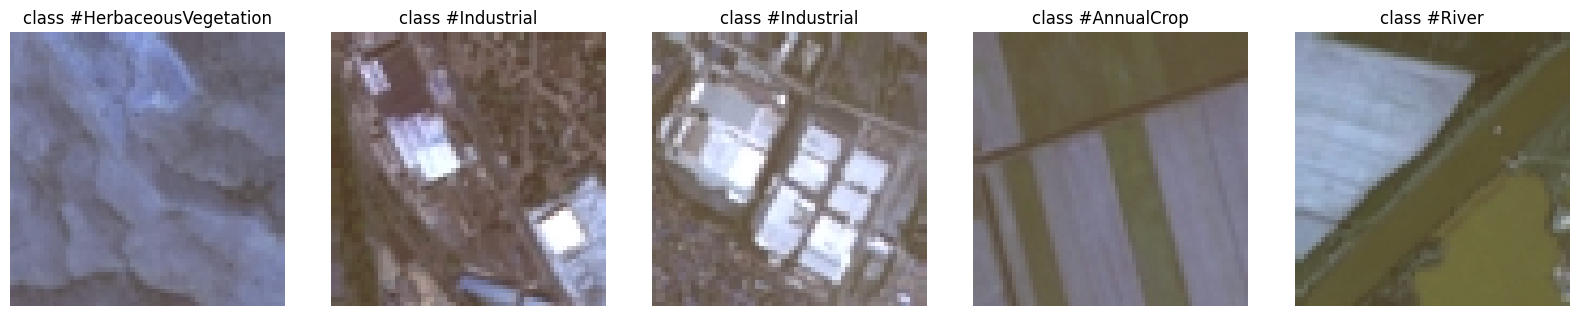

total number of training set: 25
numer of images for class HerbaceousVegetation: 5
numer of images for class Industrial: 5
numer of images for class Industrial: 5
numer of images for class AnnualCrop: 5
numer of images for class River: 5


In [12]:
num_to_show = 5
idx = np.random.choice(list(range(len(train_set_euro_sat))), num_to_show, replace=False) # randomly pick 5 pictures to show
fig = plt.figure(figsize=(16, 8))


for i in range(len(idx)):
    image, label = train_set_euro_sat[idx[i]]
    label_name = labels_id_key[label]
    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image.permute(1, 2, 0)))


plt.show()

# print number of images for each class
print('total number of training set: {}'.format(len(train_set_euro_sat)))
for i in idx:
    print('numer of images for class {}: {}'.format(labels_id_key[train_set_euro_sat.labels[i]], np.sum(train_set_euro_sat.labels==train_set_euro_sat.labels[i])))

First we need to load the model we just trained. In here the output is hardcoded to 5 as we only consider 5 classes at a time.

---



In [ ]:
# path = './Model/resnet18-model-80-accuracy.pth'
num_classes = 5
path = './drive/MyDrive/Colab Notebooks/resnet18-augmentation-2.pth'

pretrained_model = torch.load(path, map_location=torch.device('cpu'))
# pretrained_model = torch.load(path)
pretrained_model = pretrained_model.to(device)

pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now we can modify the pretrained model to classify EuroSAT_RGB images. For this I will update the last layer of this model to classify only 5 classes

In [ ]:
num_features = pretrained_model.fc[-1].in_features
pretrained_model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(labels_id_key.keys()))
).to(device)
pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Next, I am following the below steps to train the model.

I introduce a new loop in addition to the current loop to introduce different datasets and generalize the model.

In [ ]:
selected_labels = np.random.choice(range(0, 10, 1), num_of_classes, replace=False)
print(f'Selected Classes: {[labels_id_key[lbl] for lbl in selected_labels]}')

Selected Classes: ['Highway', 'AnnualCrop', 'Industrial', 'PermanentCrop', 'River']


In [ ]:
# Initialize the Weight Transforms
weights = models.ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
num_of_classes = 5

# Data Augmentation
data_transform = transforms.Compose([
    transforms.Lambda(lambda x: preprocess(x)),
    # transforms.RandomResizedCrop(84),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomRotation(degrees=15),
    # transforms.ToTensor()
    ])

# Seperate transform for test so I can control the test image
data_transform_test = transforms.Compose([
    transforms.Lambda(lambda x: preprocess(x)),
    # transforms.RandomResizedCrop(84),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomRotation(degrees=15),
    # transforms.ToTensor()
    ])

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Training loop
num_epochs = 50
num_rounds = 30

accuracy_list = []


for round in range(num_rounds):
  print(f'round {round} of {num_rounds}')

  train_set = EuroSAT(selected_labels=selected_labels,already_selected={}, phase='train', transform=data_transform)
  train_loader = DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2, pin_memory=True)

  test_set = EuroSAT(selected_labels=selected_labels,already_selected=train_set.already_selected,phase='test', transform=data_transform_test)
  test_loader = DataLoader(test_set, batch_size=5, shuffle=True, num_workers=2, pin_memory=True)

  for epoch in range(num_epochs):
      pretrained_model.train()

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          # Forward pass
          outputs = pretrained_model(inputs)

          loss = criterion(outputs, labels)

          # Backward pass
          loss.backward()
          optimizer.step()

      scheduler.step()
      if epoch % 250 == 0:
        print(f'Epoch : {epoch}, loss: {loss}')


  # Test the model on the test set
  pretrained_model.eval()
  total_test_accuracy = 0.0
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = pretrained_model(inputs)
          test_loss = criterion(outputs, labels)
          accuracy = calculate_accuracy(outputs, labels)
          total_test_accuracy += accuracy

      average_test_accuracy = total_test_accuracy / len(test_loader)
      print(f'Epoch : {epoch}, Test Accuracy: {average_test_accuracy * 100:.2f}%, Testing loss: {test_loss}')
  accuracy_list.append(average_test_accuracy)

print(f'Average Accuracy: {np.mean(accuracy_list) * 100:.2f}%')

round 0 of 30
Epoch : 0, loss: 1.048546552658081
Epoch : 49, Test Accuracy: 65.33%, Testing loss: 0.40543633699417114
round 1 of 30
Epoch : 0, loss: 1.3381155729293823
Epoch : 49, Test Accuracy: 78.67%, Testing loss: 0.66229647397995
round 2 of 30
Epoch : 0, loss: 1.0511610507965088
Epoch : 49, Test Accuracy: 77.33%, Testing loss: 0.34009265899658203
round 3 of 30
Epoch : 0, loss: 1.1978639364242554
Epoch : 49, Test Accuracy: 78.67%, Testing loss: 0.8912784457206726
round 4 of 30
Epoch : 0, loss: 0.9842780828475952
Epoch : 49, Test Accuracy: 73.33%, Testing loss: 1.018409252166748
round 5 of 30
Epoch : 0, loss: 0.8378130793571472
Epoch : 49, Test Accuracy: 74.67%, Testing loss: 0.9745197296142578
round 6 of 30
Epoch : 0, loss: 1.6491708755493164
Epoch : 49, Test Accuracy: 77.33%, Testing loss: 0.7245831489562988
round 7 of 30
Epoch : 0, loss: 1.286914348602295
Epoch : 49, Test Accuracy: 81.33%, Testing loss: 0.4350603520870209
round 8 of 30
Epoch : 0, loss: 1.3434298038482666
Epoch : 4

In [ ]:
# Save full model with architecture
save_path = './drive/MyDrive/Colab Notebooks/eurosat_model.pth'
torch.save(pretrained_model, save_path)

#### Visualization

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score

data_transform = transforms.Compose([
    transforms.Lambda(lambda x: preprocess(x)),
    # transforms.RandomResizedCrop(84),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomRotation(degrees=15),
    # transforms.ToTensor()
    ])

# Seperate transform for test so I can control the test image
data_transform_test = transforms.Compose([
    transforms.Lambda(lambda x: preprocess(x)),
    # transforms.RandomResizedCrop(84),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomRotation(degrees=15),
    # transforms.ToTensor()
    ])

selected_labels = [3, 0, 4, 6, 8]
train_set = EuroSAT(selected_labels=selected_labels,already_selected={}, phase='train', transform=data_transform)
test_set = EuroSAT(selected_labels=selected_labels,already_selected=train_set.already_selected,phase='test', transform=data_transform_test)

train_loader = DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=5, shuffle=True, num_workers=2, pin_memory=True)

path = './drive/MyDrive/Colab Notebooks/DeepLearningProject/eurosat_model.pth'

# model = torch.load(path, map_location=torch.device('cpu'))
model = torch.load(path)
model = model.to(device)

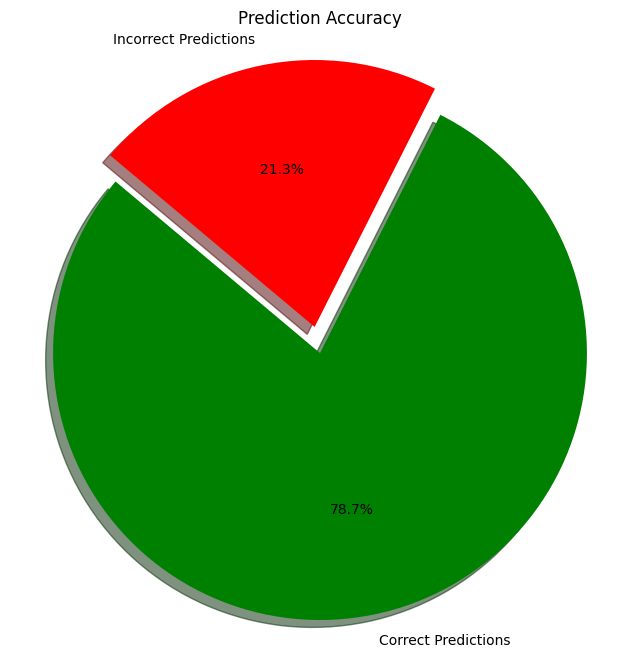

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay
model.eval()

predictions = []
true_val = []
# Make predictions using the model
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    predictions.append(predicted)
    true_val.append(labels)

# Concatenate prediction and true values along batches
all_predictions = torch.cat(predictions, dim=0)
all_true_values = torch.cat(true_val, dim=0)

# Count correct and incorrect predictions
correct_count = torch.sum(all_predictions == all_true_values).item()
incorrect_count = len(all_true_values) - correct_count


# Plot a pie chart
labels = ['Correct Predictions', 'Incorrect Predictions']
sizes = [correct_count, incorrect_count]
colors = ['green', 'red']
explode = (0.1, 0)  # explode the 1st slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Prediction Accuracy')
plt.show()


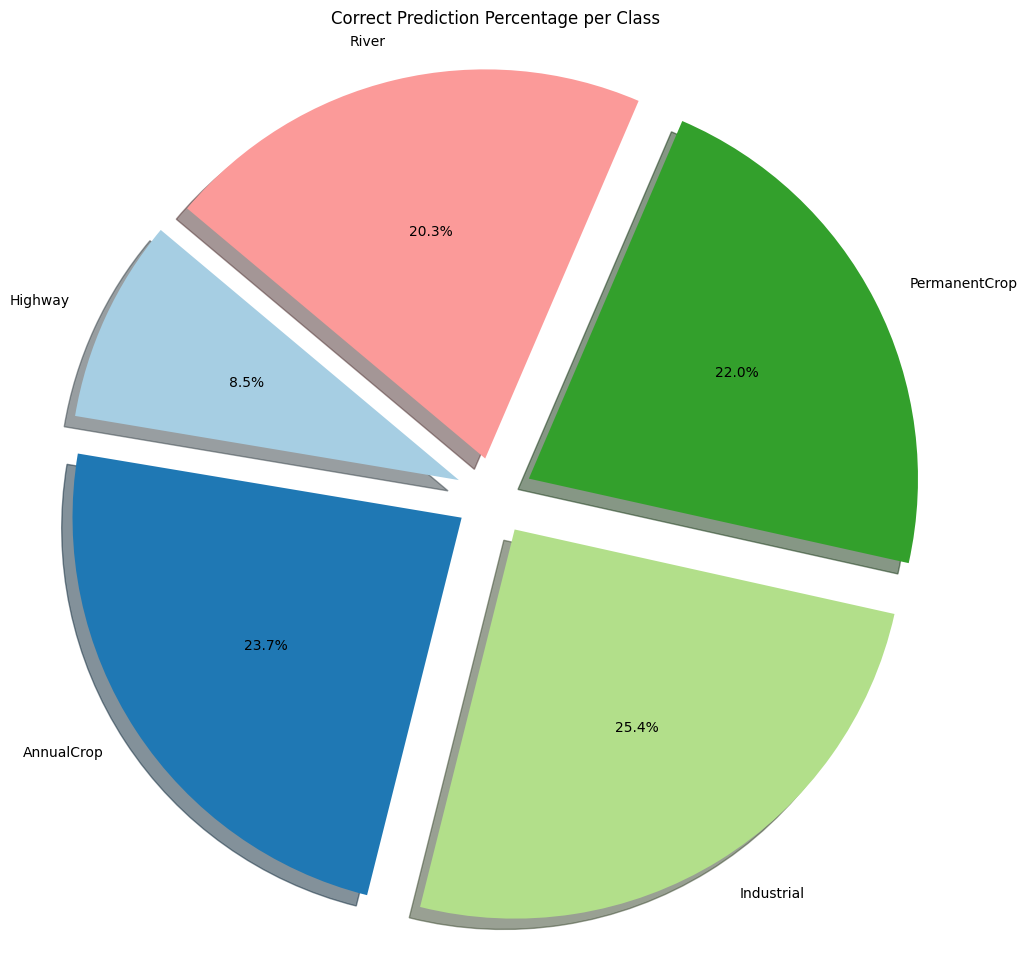

In [76]:
# Calculate correct and total counts per class
class_dict_total = {3: 0, 0: 0, 4 : 0, 6: 0, 8: 0}
class_dict_correct = {3: 0, 0: 0, 4 : 0, 6: 0, 8: 0}

for true_label, pred_label in zip(all_true_values, all_predictions):
    class_dict_total[true_label.item()] += 1
    class_dict_correct[true_label.item()] += (true_label.item() == pred_label.item())

# Calculate correct percentages per class
class_total_counts = np.array(list(class_dict_total.values()))
class_correct_counts = np.array(list(class_dict_correct.values()))
class_correct_percentages = (class_correct_counts / class_total_counts) * 100

# Plot a pie chart for correct percentages per class
labels = [labels_id_key[lbl] for lbl in selected_labels]
sizes = class_correct_percentages
colors = plt.cm.Paired(np.arange(len(labels)))
explode = [0.1] * len(labels)  # explode all slices for better visibility

plt.figure(figsize=(12, 12))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Correct Prediction Percentage per Class')
plt.show()